# Analysing Strain Introduction Impact in the Detailed Model

- In this case, we introduce the presence of another strain, which enters the system once the resident strain is established at endemic equilibrium. 
- Then, we evaluate the evolution of the age pattern over time, as well as how susceptibility changes and strain abundance
- We will consider a cross immunity parameter $\sigma_{ij}$ > 1, which is compatible with ADE assumption that once you are infected ith a strain, you become more susceptible towards other strains
- Then, we will consider other cases with $\sigma_{ij}$ < 1, which is the opposite assumption, where this clearly would represent a cross immunity in the traditional sense.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
import seaborn as sns
np.random.seed(123)

In [2]:
@np.vectorize
def beta_step(beta_0,beta_aug,t_start,t_season,t_year,t):
  # beta_0 is the basal beta
  # beta_aug is the beta at high transmission season
  # t_start is start time of the high transmission season
  # t_season is the duration of the high transmission season
  # t_year is the duration of a year (giving the function periodicity)
  # t is current time time
  # normalize time up to a year
  t_norm = t%t_year
  # and now we look for the value of the function
  if(t_norm >= t_start and t_norm <= t_start + t_season):
    value = beta_aug
  else:
    value = beta_0
  return value

In [3]:
def calculate_l_vector(alpha,l1):
    list_l = [] # creando uma lista l l1, l2, l3, .....
    elements_l = alpha.shape[0]
    for i in range(elements_l):
        # if it is the first element
        if(i == 0):
            list_l.append(l1)
        elif(i == elements_l-1): # if it is the last element (mortality term)
            list_l.append(list_l[-1]*alpha[-2]/alpha[-1])
        else: # in other case (intermediate elements)
            list_l.append(list_l[-1]*alpha[i-1]/alpha[i])
    return list_l

In [4]:
def n_groups_seasonal_model_strain(y, t, N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, sigma):
    # N is number of age groups 
    
    # classes for the new model
    S = y[0:N]  # the susceptible to everything
    I11 = y[N:2*N] # the infected with 1 for their first infection
    I21 = y[2*N:3*N]
    S2 = y[3*N:4*N] 
    S1 = y[4*N:5*N]
    I22 = y[5*N:6*N]
    I12 = y[6*N:7*N]
    R = y[7*N:8*N]
    C1 = y[8*N:9*N]
    C2 = y[9*N:]
    
    # the beta for both strains 
    beta = beta_step(beta_0,beta_aug,t_start,t_season,t_year,t)
    
    # total infected with each strain
    IT1 = sum(I11) + sum(I12) 
    IT2 = sum(I21) + sum(I22)
    
    # adding simple things to construct equations
    
    # for the first strain
    S = np.append(S,0)
    S = np.append(0,S)
    I11 = np.append(I11,0)
    I11 = np.append(0,I11)
    I21 = np.append(I21,0)
    I21 = np.append(0,I21)
    S1 = np.append(S1,0)
    S1 = np.append(0,S1)
    S2 = np.append(S2,0)
    S2 = np.append(0,S2)
    I22 = np.append(I22,0)
    I22 = np.append(0,I22)
    I12 = np.append(I12,0)
    I12 = np.append(0,I12)
    R = np.append(R,0)
    R = np.append(0,R)
    C1 = np.append(C1,0)
    C1 = np.append(0,C1)
    C2 = np.append(C2,0)
    C2 = np.append(0,C2)

    
    # for the ageing rates
    l_vec_2 = np.append(0,l_vec)
    l_vec_2 = l_vec_2[:-1]
    
    # equations themselves
    dSdt = -beta*S[1:-1]*IT1 - beta*S[1:-1]*IT2 - mu_vec*S[1:-1] - l_vec*S[1:-1] + l_vec_2*S[:-2]
    dI11dt = - gamma*I11[1:-1] - mu_vec*I11[1:-1] - l_vec*I11[1:-1] + l_vec_2*I11[:-2] + beta*S[1:-1]*IT1
    dI21dt = - gamma*I21[1:-1] - mu_vec*I21[1:-1] - l_vec*I21[1:-1] + l_vec_2*I21[:-2] + beta*S[1:-1]*IT2
    dS2dt = gamma*I11[1:-1] - beta*sigma*IT2*S2[1:-1]  - mu_vec*S2[1:-1] - l_vec*S2[1:-1] + l_vec_2*S2[:-2]
    dS1dt = gamma*I21[1:-1] - beta*sigma*IT1*S1[1:-1] - mu_vec*S1[1:-1] - l_vec*S1[1:-1] + l_vec_2*S1[:-2]
    dI22dt = beta*sigma*IT2*S2[1:-1] - gamma*I22[1:-1] - mu_vec*I22[1:-1] - l_vec*I22[1:-1] + l_vec_2*I22[:-2]
    dI12dt = beta*sigma*IT1*S1[1:-1] - gamma*I12[1:-1] - mu_vec*I12[1:-1] - l_vec*I12[1:-1] + l_vec_2*I12[:-2]
    dRdt = gamma*I22[1:-1] + gamma*I12[1:-1] - mu_vec*R[1:-1] - l_vec*R[1:-1] + l_vec_2*R[:-2]
    
    dSdt[0] = dSdt[0] + nu # born totally susceptible to both
    
    
    dC1dt = beta*(S[1:-1]+sigma*S1[1:-1])*IT1
    dC2dt = beta*(S[1:-1]+sigma*S2[1:-1])*IT2
    
    return np.array([dSdt, dI11dt, dI21dt, dS2dt, dS1dt, dI22dt, dI12dt, dRdt, dC1dt, dC2dt]).flatten()

In [5]:
def modify_initial_condition(y):
    y_aux = y.copy()
    y_tmp = y.copy()
    y_tmp[:N] = (y_aux[:N]*pop - 1)/pop # suscteptible reduction (of totally susceptible)
    y_tmp[N:2*N] = (y_aux[N:2*N]*pop + 1)/pop # infected grow
    y_tmp[8*N:9*N] = (y_aux[8*N:9*N]*pop + 1)/pop  # increase in new cases per day
    return y_tmp

In [6]:
def define_initial_condition():
    y0 = np.zeros(N*10)
    y0[:N] = np.array([alpha1,alpha2,alpha3,alpha4,(alpha5*pop-1)/pop,alpha6,alpha7,alpha8,alpha9,alpha10,alpha11])
    y0[N:2*N] = np.array([0,   0,      0,     0,       1/pop,            0,    0,     0,     0,     0,      0])
    y0[8*N:9*N] = np.array([0,   0,      0,     0,       1/pop,            0,    0,     0,     0,     0,      0])
    return y0

In [7]:
def modify_initial_condition_new(y):
    y_aux = y.copy()
    y_tmp = y.copy()
    # first strain
    y_tmp[:N] = (y_aux[:N]*pop - 1)/pop # suscteptible reduction (of totally susceptible)
    y_tmp[N:2*N] = (y_aux[N:2*N]*pop + 1)/pop # infected grow
    y_tmp[8*N:9*N] = (y_aux[8*N:9*N]*pop + 1)/pop  # increase in new cases per day
    # second strain
    y_tmp[:N] = (y_aux[:N]*pop - 1)/pop # susceptiptible reduction (of totally susceptible)
    y_tmp[2*N:3*N] = (y_aux[2*N:3*N]*pop + 1)/pop # infected grow (infected for the first time by second strain)
    y_tmp[9*N:] = (y_aux[9*N:]*pop + 1)/pop  # increase in new cases per day
    return y_tmp

In [8]:
# number of age groups
N = 11

# number of people per age group
alpha1 = 793061 # 0 to 4 
alpha2 = 803773 # 5 to 9
alpha3 = 836496 # 10 to 14
alpha4 = 877970 # 15 to 19
alpha5 = 1960304 # 20 to 29
alpha6 = 1995084 # 30 to 39
alpha7 = 1666076 # 40 to 49
alpha8 = 1319655 # 50 to 59
alpha9 = 878162 # 60 to 59
alpha10 = 476538 # 70 to 79 
alpha11 = 245667 # 80+

# creating vector of alphas
alpha_pop = np.array([alpha1, alpha2, alpha3, alpha4, alpha5, alpha6, 
                  alpha7, alpha8, alpha9, alpha10, alpha11])

# total population 
pop = alpha_pop.sum()

# dividing by total population
alpha1 = alpha1/pop
alpha2 = alpha2/pop
alpha3 = alpha3/pop
alpha4 = alpha4/pop
alpha5 = alpha5/pop
alpha6 = alpha6/pop
alpha7 = alpha7/pop
alpha8 = alpha8/pop
alpha9 = alpha9/pop
alpha10 = alpha10/pop
alpha11 = alpha11/pop

# creating a new vector of alphas (divided by overall population, as proportions)
alpha = np.array([alpha1, alpha2, alpha3, alpha4, alpha5, alpha6, 
                  alpha7, alpha8, alpha9, alpha10, alpha11])


# demographical constants for the model
l1 = 1/(365*5) # how long does the first age group last (in days)?
nu = l1*alpha[0] # calculating the corresponding birth rate
l_vec = calculate_l_vector(alpha, l1) # calculating l aging elements + coupled death rate
mu_vec = np.array([0,0,0,0,0,0,0,0,0,0, l_vec[-1]]) # death rates array
# calculating aging rates vector
l_vec = l_vec[:-1] 
l_vec.append(0)
l_vec = np.array(l_vec)


# disease parameters
gamma = 1/(7.0)
beta_0 = 0.0*gamma

# year parameters for disease seasonality
t_year = 365
t_start = 0
t_season = 60

# a characteristic season
t_season_single = np.arange(0,365,1)

# number of seasons to simulate
seasons = 40

In [9]:
# defining the beta values
beta_1 = 2.0*gamma
beta_2 = 5.0*gamma

## Part 1: Evolution of time series for different $\beta$ values

Original Strain


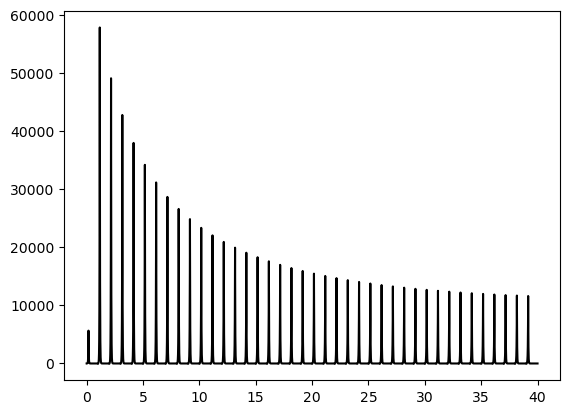

New Strain


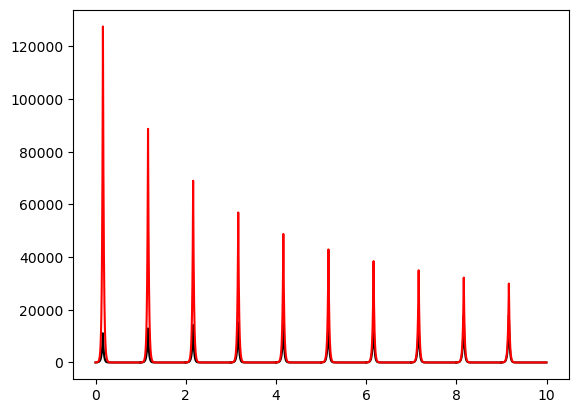

In [37]:
beta_aug = beta_1

sigma = 1.5
y0 = define_initial_condition()

print('Original Strain')
for season in np.arange(seasons):
    ret = odeint(n_groups_seasonal_model_strain, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, sigma))
    y0 = ret[-1,:].copy()
    if(season != seasons - 1):
        y0 = modify_initial_condition(y0)
    plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1)*pop, label = season, color = 'k')
    #plt.scatter((season*365)/365,y0[N:2*N].sum())
#plt.legend()
plt.show()

y0 = modify_initial_condition_new(y0)

print('New Strain')
for season in np.arange(10):
    ret = odeint(n_groups_seasonal_model_strain, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, sigma))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition_new(y0)
    IT1 = ret[:,N:2*N] + ret[:,6*N:7*N]
    IT2 = ret[:,2*N:3*N] + ret[:,5*N:6*N]
    plt.plot((t_season_single+season*365)/365,IT1.sum(axis=1)*pop, label = season, color = 'k')
    plt.plot((t_season_single+season*365)/365,IT2.sum(axis=1)*pop, label = season, color = 'r')
    #plt.scatter((season*365)/365,y0[N:2*N].sum())
#plt.legend()
plt.show()


Original Strain


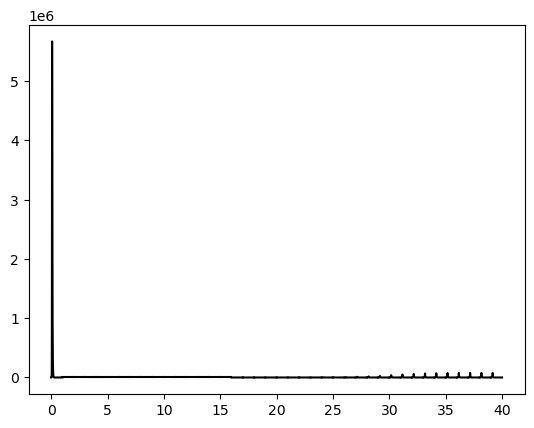

New Strain


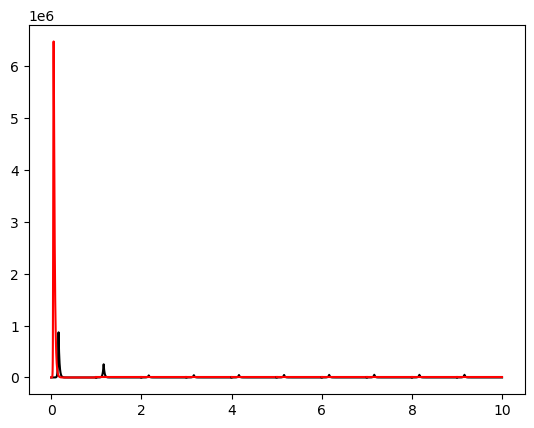

In [36]:
beta_aug = beta_2

sigma = 1.5
y0 = define_initial_condition()

print('Original Strain')
for season in np.arange(seasons):
    ret = odeint(n_groups_seasonal_model_strain, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, sigma))
    y0 = ret[-1,:].copy()
    if(season != seasons - 1):
        y0 = modify_initial_condition(y0)
    plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1)*pop, label = season, color = 'k')
    #plt.scatter((season*365)/365,y0[N:2*N].sum())
#plt.legend()
plt.show()

y0 = modify_initial_condition_new(y0)

print('New Strain')
for season in np.arange(10):
    ret = odeint(n_groups_seasonal_model_strain, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, sigma))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition_new(y0)
    IT1 = ret[:,N:2*N] + ret[:,6*N:7*N]
    IT2 = ret[:,2*N:3*N] + ret[:,5*N:6*N]
    plt.plot((t_season_single+season*365)/365,IT1.sum(axis=1)*pop, label = season, color = 'k')
    plt.plot((t_season_single+season*365)/365,IT2.sum(axis=1)*pop, label = season, color = 'r')
    #plt.scatter((season*365)/365,y0[N:2*N].sum())
#plt.legend()
plt.show()


## Part 2: Evolution of age pattern for different $\beta$ values - ADE assumption

Original Strain
New Strain - summing for all infections


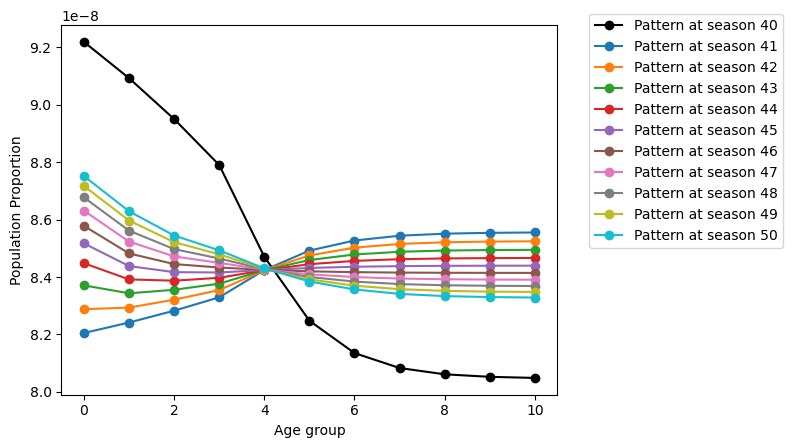

In [49]:
beta_aug = beta_1

sigma = 1.5
y0 = define_initial_condition()

print('Original Strain')
for season in np.arange(seasons):
    ret = odeint(n_groups_seasonal_model_strain, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, sigma))
    y0 = ret[-1,:].copy()
    inf_total_1 = pop*(ret[1:,8*N:9*N] - ret[:-1,8*N:9*N]).sum(axis = 1).sum()
    prop_pop = alpha*pop*inf_total_1
    if(season != seasons - 1):
        y0 = modify_initial_condition(y0)
    if(season == seasons - 1):
        plt.plot((pop/prop_pop)*(ret[1:,8*N:9*N] - ret[:-1,8*N:9*N]).sum(axis = 0), '-o', label = 'Pattern at season 40', color = 'k')
        plt.ylabel('Population Proportion')
        plt.xlabel('Age group')

y0 = modify_initial_condition_new(y0)

print('New Strain - summing for all infections')

for season in np.arange(10):
    ret = odeint(n_groups_seasonal_model_strain, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, sigma))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition_new(y0)
    inf_total_1 = pop*(ret[1:,8*N:9*N] - ret[:-1,8*N:9*N]).sum(axis = 1).sum()
    inf_total_2 = pop*(ret[1:,9*N:] - ret[:-1,9*N:]).sum(axis = 1).sum()
    prop_pop = alpha*pop*(inf_total_1 + inf_total_2)
    plt.plot((pop/prop_pop)*((ret[1:,8*N:9*N] - ret[:-1,8*N:9*N]).sum(axis = 0) + (ret[1:,9*N:] - ret[:-1,9*N:]).sum(axis = 0)), '-o', label = 'Pattern at season '+str(season+seasons+1))
    plt.ylabel('Population Proportion')
    plt.xlabel('Age group')
    
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.show()

Original Strain
New Strain - summing for all infections


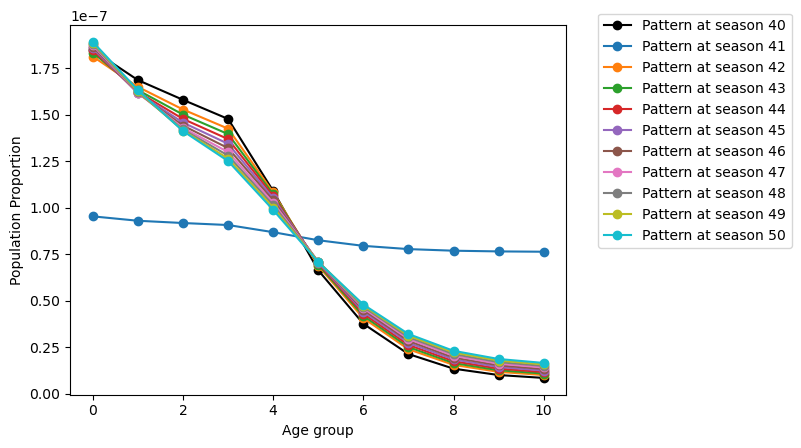

In [50]:
beta_aug = beta_2

sigma = 1.5
y0 = define_initial_condition()

print('Original Strain')
for season in np.arange(seasons):
    ret = odeint(n_groups_seasonal_model_strain, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, sigma))
    y0 = ret[-1,:].copy()
    inf_total_1 = pop*(ret[1:,8*N:9*N] - ret[:-1,8*N:9*N]).sum(axis = 1).sum()
    prop_pop = alpha*pop*inf_total_1
    if(season != seasons - 1):
        y0 = modify_initial_condition(y0)
    if(season == seasons - 1):
        plt.plot((pop/prop_pop)*(ret[1:,8*N:9*N] - ret[:-1,8*N:9*N]).sum(axis = 0), '-o', label = 'Pattern at season 40', color = 'k')
        plt.ylabel('Population Proportion')
        plt.xlabel('Age group')

y0 = modify_initial_condition_new(y0)

print('New Strain - summing for all infections')

for season in np.arange(10):
    ret = odeint(n_groups_seasonal_model_strain, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, sigma))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition_new(y0)
    inf_total_1 = pop*(ret[1:,8*N:9*N] - ret[:-1,8*N:9*N]).sum(axis = 1).sum()
    inf_total_2 = pop*(ret[1:,9*N:] - ret[:-1,9*N:]).sum(axis = 1).sum()
    prop_pop = alpha*pop*(inf_total_1 + inf_total_2)
    plt.plot((pop/prop_pop)*((ret[1:,8*N:9*N] - ret[:-1,8*N:9*N]).sum(axis = 0) + (ret[1:,9*N:] - ret[:-1,9*N:]).sum(axis = 0)), '-o', label = 'Pattern at season '+str(season+seasons+1))
    plt.ylabel('Population Proportion')
    plt.xlabel('Age group')
    
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.show()

## Part 2: Evolution of age pattern for different $\beta$ values - cross-immunity assumption

Original Strain
New Strain - summing for all infections


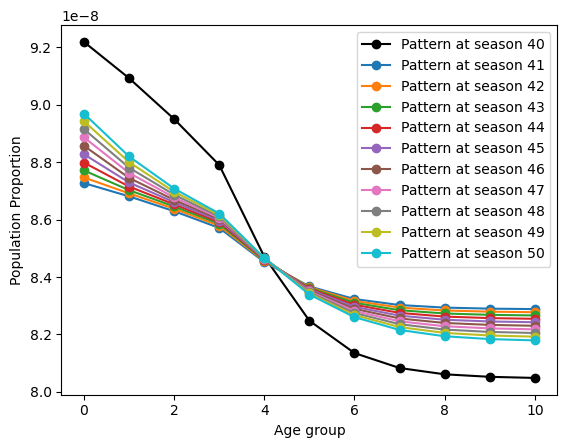

In [52]:
beta_aug = beta_1

sigma = 0.8
y0 = define_initial_condition()

print('Original Strain')
for season in np.arange(seasons):
    ret = odeint(n_groups_seasonal_model_strain, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, sigma))
    y0 = ret[-1,:].copy()
    inf_total_1 = pop*(ret[1:,8*N:9*N] - ret[:-1,8*N:9*N]).sum(axis = 1).sum()
    prop_pop = alpha*pop*inf_total_1
    if(season != seasons - 1):
        y0 = modify_initial_condition(y0)
    if(season == seasons - 1):
        plt.plot((pop/prop_pop)*(ret[1:,8*N:9*N] - ret[:-1,8*N:9*N]).sum(axis = 0), '-o', label = 'Pattern at season 40', color = 'k')
        plt.ylabel('Population Proportion')
        plt.xlabel('Age group')

y0 = modify_initial_condition_new(y0)

print('New Strain - summing for all infections')

for season in np.arange(10):
    ret = odeint(n_groups_seasonal_model_strain, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, sigma))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition_new(y0)
    inf_total_1 = pop*(ret[1:,8*N:9*N] - ret[:-1,8*N:9*N]).sum(axis = 1).sum()
    inf_total_2 = pop*(ret[1:,9*N:] - ret[:-1,9*N:]).sum(axis = 1).sum()
    prop_pop = alpha*pop*(inf_total_1 + inf_total_2)
    plt.plot((pop/prop_pop)*((ret[1:,8*N:9*N] - ret[:-1,8*N:9*N]).sum(axis = 0) + (ret[1:,9*N:] - ret[:-1,9*N:]).sum(axis = 0)), '-o', label = 'Pattern at season '+str(season+seasons+1))
    plt.ylabel('Population Proportion')
    plt.xlabel('Age group')
    
plt.legend()
plt.show()

Original Strain
New Strain - summing for all infections


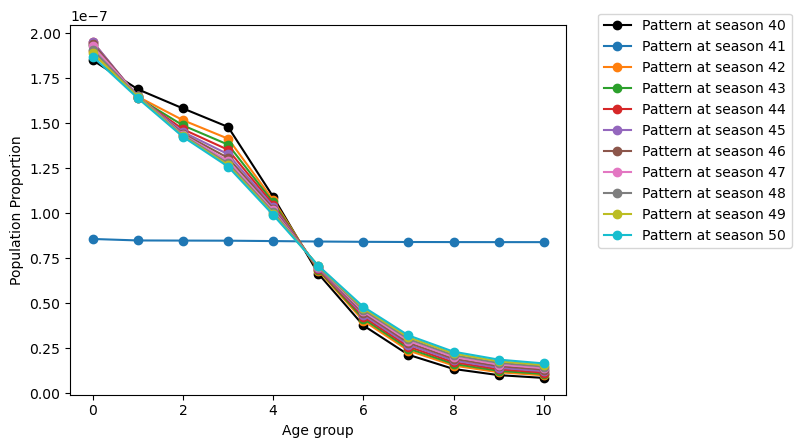

In [54]:
beta_aug = beta_2

sigma = 0.8
y0 = define_initial_condition()

print('Original Strain')
for season in np.arange(seasons):
    ret = odeint(n_groups_seasonal_model_strain, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, sigma))
    y0 = ret[-1,:].copy()
    inf_total_1 = pop*(ret[1:,8*N:9*N] - ret[:-1,8*N:9*N]).sum(axis = 1).sum()
    prop_pop = alpha*pop*inf_total_1
    if(season != seasons - 1):
        y0 = modify_initial_condition(y0)
    if(season == seasons - 1):
        plt.plot((pop/prop_pop)*(ret[1:,8*N:9*N] - ret[:-1,8*N:9*N]).sum(axis = 0), '-o', label = 'Pattern at season 40', color = 'k')
        plt.ylabel('Population Proportion')
        plt.xlabel('Age group')

y0 = modify_initial_condition_new(y0)

print('New Strain - summing for all infections')

for season in np.arange(10):
    ret = odeint(n_groups_seasonal_model_strain, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, sigma))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition_new(y0)
    inf_total_1 = pop*(ret[1:,8*N:9*N] - ret[:-1,8*N:9*N]).sum(axis = 1).sum()
    inf_total_2 = pop*(ret[1:,9*N:] - ret[:-1,9*N:]).sum(axis = 1).sum()
    prop_pop = alpha*pop*(inf_total_1 + inf_total_2)
    plt.plot((pop/prop_pop)*((ret[1:,8*N:9*N] - ret[:-1,8*N:9*N]).sum(axis = 0) + (ret[1:,9*N:] - ret[:-1,9*N:]).sum(axis = 0)), '-o', label = 'Pattern at season '+str(season+seasons+1))
    plt.ylabel('Population Proportion')
    plt.xlabel('Age group')
    
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.show()

## Part 3: susceptibility profile in the case of ADE

In [73]:
beta_aug = beta_2

sigma = 0.8
y0 = define_initial_condition()

sus_prof_1 = []
sus_prof_2 = []

print('Original Strain')
for season in np.arange(seasons):
    ret = odeint(n_groups_seasonal_model_strain, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, sigma))
    y0 = ret[-1,:].copy()
    inf_total_1 = pop*(ret[1:,8*N:9*N] - ret[:-1,8*N:9*N]).sum(axis = 1).sum()
    prop_pop = alpha*pop*inf_total_1
    if(season != seasons - 1):
        y0 = modify_initial_condition(y0)
    if(season == seasons - 1):
        #plt.plot((pop/prop_pop)*(ret[1:,8*N:9*N] - ret[:-1,8*N:9*N]).sum(axis = 0), '-o', label = 'Pattern at season 40', color = 'k')
        #plt.ylabel('Population Proportion')
        #plt.xlabel('Age group')
        sus_prof_1.append(list(100*(ret[-1,3*N:4*N] + ret[-1,7*N:8*N])/alpha))
        sus_prof_2.append(list(100*(ret[-1,4*N:5*N] + ret[-1,7*N:8*N])/alpha))
        
y0 = modify_initial_condition_new(y0)

print('New Strain - summing for all infections')

for season in np.arange(10):
    ret = odeint(n_groups_seasonal_model_strain, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, sigma))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition_new(y0)
    inf_total_1 = pop*(ret[1:,8*N:9*N] - ret[:-1,8*N:9*N]).sum(axis = 1).sum()
    inf_total_2 = pop*(ret[1:,9*N:] - ret[:-1,9*N:]).sum(axis = 1).sum()
    prop_pop = alpha*pop*(inf_total_1 + inf_total_2)
    sus_prof_1.append(list(100*(ret[-1,3*N:4*N] + ret[-1,7*N:8*N])/alpha))
    sus_prof_2.append(list(100*(ret[-1,4*N:5*N] + ret[-1,7*N:8*N])/alpha))
    #plt.plot((pop/prop_pop)*((ret[1:,8*N:9*N] - ret[:-1,8*N:9*N]).sum(axis = 0) + (ret[1:,9*N:] - ret[:-1,9*N:]).sum(axis = 0)), '-o', label = 'Pattern at season '+str(season+seasons+1))
    #plt.ylabel('Population Proportion')
    #plt.xlabel('Age group')
    

Original Strain
New Strain - summing for all infections


In [74]:
sus_prof_1 = np.array(sus_prof_1)
sus_prof_2 = np.array(sus_prof_2)

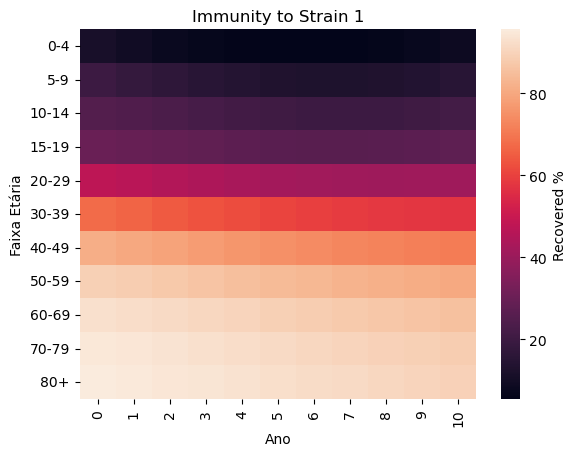

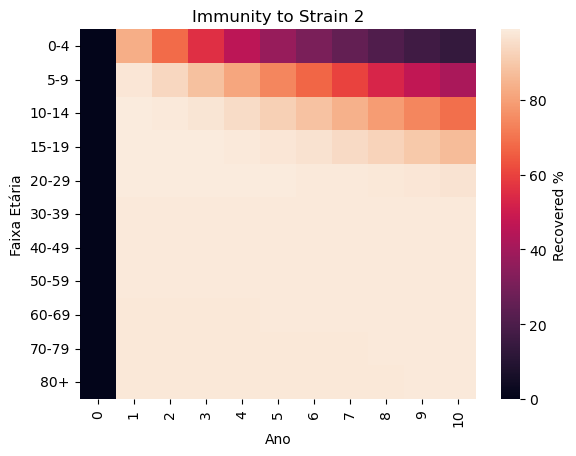

In [75]:
# recovered against 1
faixas_etarias = ['0-4','5-9','10-14','15-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79','80+']

ax = sns.heatmap(sus_prof_1.T)
ax.collections[0].colorbar.set_label("Recovered %")
ax.set(xticklabels = np.arange(11),
       yticklabels =faixas_etarias,
      xlabel="Ano",
      ylabel="Faixa Etária")
plt.xticks(rotation = 'vertical')
plt.yticks(rotation = 'horizontal')
plt.title('Immunity to Strain 1')
plt.show()

# recovered against 2
faixas_etarias = ['0-4','5-9','10-14','15-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79','80+']

ax = sns.heatmap(sus_prof_2.T)
ax.collections[0].colorbar.set_label("Recovered %")
ax.set(xticklabels = np.arange(11),
       yticklabels =faixas_etarias,
      xlabel="Ano",
      ylabel="Faixa Etária")
plt.xticks(rotation = 'vertical')
plt.yticks(rotation = 'horizontal')
plt.title('Immunity to Strain 2')
plt.show()